In [ ]:
import os
import sys
ongoogle = False
MyData=False
train_model=False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    ongoogle=True
    if MyData:
      datadir='/content/drive/My Drive/Output_ML_Acc'
    else:
      datadir='/content/drive/My Drive/CAS AML HAR/motion-sense/data'

    os.chdir(datadir)
    sys.path.insert(0,'/content/drive/My Drive/CAS AML HAR/motion-sense/data')
    
except ModuleNotFoundError:
    os.chdir('d:/data/unibe/CAS-AML-Motion/motion-sense/data')
    
    #%tensorflow_version 1.x

from matplotlib import  pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
#from imageio import imread
import pickle
from PIL import Image
from time import time as timer
import requests
import zipfile
import time
import os
import csv
import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import IPython


#import umap
from scipy.stats import entropy
import re

squeeze = 50
subjectre=re.compile('^[sub_]*([0-9]+)\.csv')
labels= []
for i in range(squeeze):
    labels += ["attitude.roll","attitude.pitch","attitude.yaw","userAcceleration.x","userAcceleration.y","userAcceleration.z"] 

activity = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
data_array=[]
if MyData:
  Adatadir=os.path.join(datadir,'Output_ML_Acc')
else:
  Adatadir=os.path.join(datadir,'A_DeviceMotion_data')
def get_csv_raw(csvfile):
    reader = csv.reader(csvfile)
    raw = []
    rawidx=-1
    for row in reader:
        # Skip Header
        if reader.line_num <=1: continue
        lineindex=int(reader.line_num - 2)
        if lineindex % squeeze == 0 or rawidx== -1:
            rawidx += 1
            raw.append([])
        rawrow = []
        # Get Attitude (1-3) and userAcceleration (10-12) from each line
        for i in [1,2,3,4,5,6]: 
            try:
                rawrow += [ float(row[i]) ]
            except:
                # Replace invalid values by 0
                rawrow += [ 0.0 ]
        # Add label as last elements of each squeezed row, the three zeroes are for magnetometer values
        rawrow += [ 0, 0, 0, subjectNr, activity[act] ]
        rawrow2 = []
        for i in rawrow:
            rawrow2 += [ i ]
        raw[rawidx] += [ rawrow2 ]
    return raw[:rawidx-1]

exercise_raw=[]
for exercise in os.listdir(Adatadir):
    act = exercise.split('_')[0]
    print (act)
    for subjectFile in os.listdir(os.path.join(Adatadir,exercise)):
        m = subjectre.search(subjectFile)
        if m:
          subjectNr = int(m.group(1))
          exercise_raw += get_csv_raw(open(os.path.join(Adatadir,exercise,subjectFile)))

            
vals = np.zeros((len(exercise_raw), len(exercise_raw[0]), len(exercise_raw[0][0])))
for i in range(len(exercise_raw)-1):
    for k in range(squeeze-1):
        vals[i,k] = exercise_raw[i][k]
vals.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ups
wlk
std
wlk
sit
std
jog
ups
wlk
sit
ups
dws
dws
jog
dws


(27712, 50, 11)

In [ ]:
# Own Data array([-0.035744,  0.122086,  0.311768, -2.08126 ,  2.080312, 13.070646,
#        0.      ,  0.      ,  0.      ,  1.      ,  5.      ])
vals[9,2]

array([-0.035744,  0.122086,  0.311768, -2.08126 ,  2.080312, 13.070646,
        0.      ,  0.      ,  0.      ,  1.      ,  5.      ])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
import keras

## Train / Test Split
X=vals[:,:,:6]
Y=vals[:,0,10]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=777)

n_train=X_train.shape[0]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, n_train)

Y_train = Y_train.reshape(-1,1)
import pickle
if train_model:
  ## Scaler
  scaler = RobustScaler()
  scaler = scaler.fit(X_train.reshape(X_train.shape[1]*X_train.shape[0],6))
  with open("scaler", "wb") as f: 
      pickle.dump(scaler, f)
  ## One Hot Encoding
  one = OneHotEncoder(handle_unknown='ignore', sparse=False)
  one = one.fit(Y_train)
  with open("encoder", "wb") as f: 
     pickle.dump(one, f)
else:
  with open("encoder", "rb") as f: 
    one = pickle.load(f)
    print(one)
  with open("scaler","rb") as f:
    scaler = pickle.load(f)

for a in [X_train, X_test]:
  for i in range(len(a)):
    a[i][:] = scaler.transform (a[i][:])
print(X_train.shape,X_train[3][7])

Y_test = one.transform(Y_test.reshape(-1,1))#[:,0]
Y_train = one.transform(Y_train)#[:,0]

print(Y_test.shape, Y_test[:9])


(22169, 50, 6) (22169,) (5543, 50, 6) (5543,) 22169
OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)
(22169, 50, 6) [-0.93417303  0.90154953  0.04293507 -1.86308349 -1.07707362  1.12636867]
(5543, 6) [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


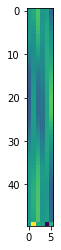

In [ ]:
#print(Y_test.shape, Y_test[:9])
#print(Y_test[:,0].shape)
import matplotlib
matplotlib.pyplot.imshow(X_test[8])


In [ ]:
one.inverse_transform(model.predict(X_test[9]))

array([[3.]])

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv1D(filters=6, kernel_size=6,strides=2,input_shape=[X_train.shape[1], X_train.shape[2]]))
model.add(keras.layers.Bidirectional( keras.layers.LSTM(units=128, 
         input_shape=[X_train.shape[1] /2, X_train.shape[2]]
)))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(Y_test.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 23, 6)             222       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               138240    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 774       
Total params: 172,132
Trainable params: 172,132
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## This replaces Conv1d above
# model.add(keras.layers.Bidirectional( keras.layers.LSTM(units=128, 
#          input_shape=[X_train.shape[1], X_train.shape[2]]
# )))

In [ ]:
if train_model:
  history = model.fit(
      X_train, Y_train,
      epochs=50,
      batch_size=64,
      validation_split=0.1,
      shuffle=False
  )
  model.save('simple_model')
else:
  model = keras.models.load_model('simple_model')

Epoch 1/50
62/62 [==============================] - 5s 33ms/step - loss: 1.4742 - acc: 0.4353 - val_loss: 0.7071 - val_acc: 0.7626
Epoch 2/50
62/62 [==============================] - 1s 18ms/step - loss: 0.7661 - acc: 0.7207 - val_loss: 0.5131 - val_acc: 0.8059
Epoch 3/50
62/62 [==============================] - 1s 18ms/step - loss: 0.5906 - acc: 0.7830 - val_loss: 0.4634 - val_acc: 0.8447
Epoch 4/50
62/62 [==============================] - 1s 18ms/step - loss: 0.5199 - acc: 0.8107 - val_loss: 0.4352 - val_acc: 0.8447
Epoch 5/50
62/62 [==============================] - 1s 18ms/step - loss: 0.4524 - acc: 0.8223 - val_loss: 0.3752 - val_acc: 0.8607
Epoch 6/50
62/62 [==============================] - 1s 18ms/step - loss: 0.3980 - acc: 0.8471 - val_loss: 0.3265 - val_acc: 0.8767
Epoch 7/50
62/62 [==============================] - 1s 18ms/step - loss: 0.3332 - acc: 0.8648 - val_loss: 0.3009 - val_acc: 0.8927
Epoch 8/50
62/62 [==============================] - 1s 18ms/step - loss: 0.2898 - a

INFO:tensorflow:Assets written to: simple_model/assets


INFO:tensorflow:Assets written to: simple_model/assets


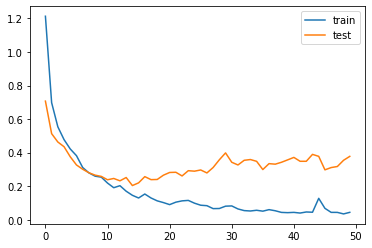

In [ ]:
if train_model:
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend();

[Text(0, 0.5, 'dws'),
 Text(0, 1.5, 'jog'),
 Text(0, 2.5, 'sit'),
 Text(0, 3.5, 'std'),
 Text(0, 4.5, 'ups'),
 Text(0, 5.5, 'wlk')]

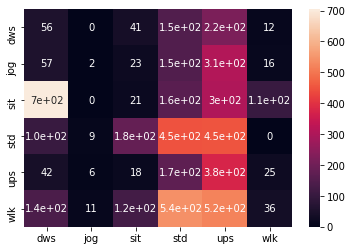

In [ ]:
  from sklearn.metrics import confusion_matrix
  y_pred = model.predict(X_test)

  act = ('dws','jog','sit','std','ups','wlk')
  import seaborn as sns

  cm = confusion_matrix(one.inverse_transform(Y_test), one.inverse_transform(y_pred), labels=None, sample_weight=None, normalize=None)
  f = sns.heatmap(cm, annot=True)
  f.set_xticklabels(act)
  f.set_yticklabels(act)

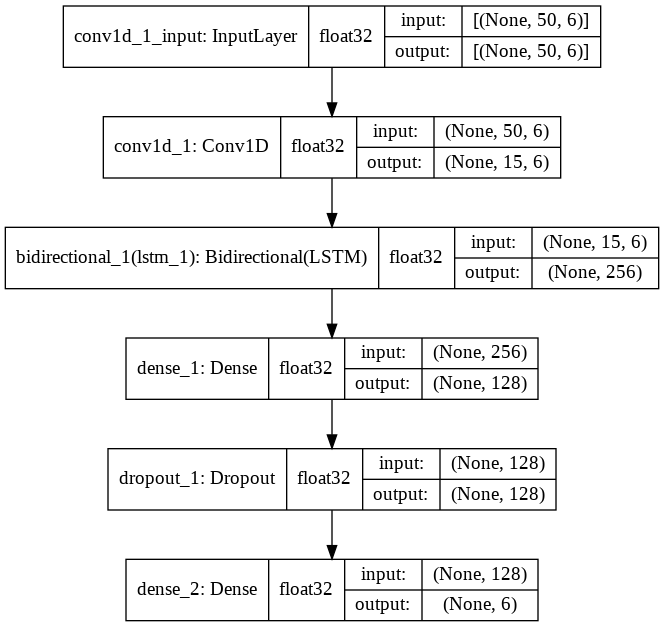

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
44/44 [==============================] - 0s 8ms/step - loss: 8.6186 - acc: 0.1698
test loss, test acc: [8.618638038635254, 0.16976366937160492]


In [ ]:
def test_model(model, X_val, Y_val, batch_size, W_comb=None, H_comb=None):
    if not W_comb:
        W_comb = X_val.shape[1]
    if not H_comb:
        H_comb = list(range(X_val.shape[2]))
    val_accuracy = tf.keras.metrics.Accuracy()
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    val_dataset = val_dataset.batch(batch_size)
    for (X, Y) in val_dataset:
        #X = X[:,:,H_comb]
        #X = tf.image.resize(X, (W_comb, len(H_comb)))
        logits = model(X)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y)
    return val_accuracy.result()
W_combinations = list(np.arange(16,129,16))
H_combinations = [[0,1,2], [3,4,5], [6,7,8], 
                  [0,1,2,3,4,5], [0,1,2,6,7,8],
                  [3,4,5,0,1,2], [3,4,5,6,7,8],
                  [6,7,8,0,1,2], [6,7,8,3,4,5],
                  [0,1,2,3,4,5,6,7,8],[0,1,2,6,7,8,3,4,5],
                  [3,4,5,0,1,2,6,7,8],[3,4,5,6,7,8,0,1,2], 
                  [6,7,8,3,4,5,0,1,2],[6,7,8,0,1,2,3,4,5]] ## Acc & Gyr & Mgn

W_combinations_validation = W_combinations
H_combinations_validation = [[0,1,2], [3,4,5], [6,7,8],
                  [0,1,2,3,4,5], [0,1,2,6,7,8],[3,4,5,6,7,8],
                  [0,1,2,3,4,5,6,7,8]]
n_batch_per_train_setp = 5
run=1
best_accuracy_record = np.zeros((len(W_combinations_validation),len(H_combinations_validation)))
for w in range(len(W_combinations_validation)):
    for h in range(len(H_combinations_validation)):
        print (h)
        best_accuracy_record[w,h] = test_model(model, X_test, Y_test, 128,
                                            W_combinations_validation[w],
                                            H_combinations_validation[h])

print("\n Run {} *** Mean of Test Accuraccies: {:.3f}".format(run, np.mean(best_accuracy_record)))
print("\n Run {} *** Test Accuraccies: {} ".format(run, (best_accuracy_record)))

0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6

 Run 1 *** Mean of Test Accuraccies: 0.022

 Run 1 *** Test Accuraccies: [[0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]
 [0.02153558 0.02153558 0.02153558 0.02153558 0.02153558 0.02153558
  0.02153558]] 


In [ ]:
logits = model(X_train[0:7])

In [ ]:
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)